# importing the libraries 


In [ ]:
import pandas as pd 
import numpy as np 
from catboost import CatBoostRegressor 
from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error 
from prettytable import PrettyTable


In [ ]:
pip install catboost 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
pip install xgboost 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install prettytable 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#loading the dataset in the notebook and droping the row_id since we not allowed to use it.

df = pd.read_csv('/content/train_0OECtn8.csv')
df.drop('row_id', axis = 1, inplace = True)

In [ ]:
skewness = df.skew()
print(skewness)

user_id            -0.003594
category_id         0.484276
video_id            0.079629
age                 0.579960
followers           0.414164
views               0.043662
engagement_score   -0.855630
dtype: float64


<ipython-input-9-bcf117d781b8>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.skew()


# Doing a EDA analysis on the given dataset 


In order to get the realation of the given target variable with the other variable we will perform a short and concise EDA analysis 


In [ ]:
df.head()

,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,19990,37,128,24,Male,Student,180,1000,4.33
1,5304,32,132,14,Female,Student,330,714,1.79
2,1840,12,24,19,Male,Student,180,138,4.35
3,12597,23,112,19,Male,Student,220,613,3.77
4,13626,23,112,27,Male,Working Professional,220,613,3.13


In [ ]:
df.shape

(89197, 9)

In [ ]:
df.isnull().sum()

user_id             0
category_id         0
video_id            0
age                 0
gender              0
profession          0
followers           0
views               0
engagement_score    0
dtype: int64

Since the given data set doesn't have any missing values in it hence we will not have to use any missing vales technique to input the missing values 

In [ ]:
# No. of Unique User in the given dataset 
df['user_id'].nunique()

27734

Since we are doing a User based Engagment Score analysis we would have to find the unique user variables in the given dataset 

In [ ]:
df.dtypes

user_id               int64
category_id           int64
video_id              int64
age                   int64
gender               object
profession           object
followers             int64
views                 int64
engagement_score    float64
dtype: object

By using the dtypes command we find out that profession and foloowers are given as object although they are stored as numbers the dataset 

In [ ]:
# distribution of the num features 
num_features = ['age','followers','views']
categ_features = ['user_id','category_id','video_id','gender','profession']

Although the columns like user_id, categorical_id etc are represented by numerical datatype the represent categorical features in the dataset hence we wil be using the categ_feature function to put them together.


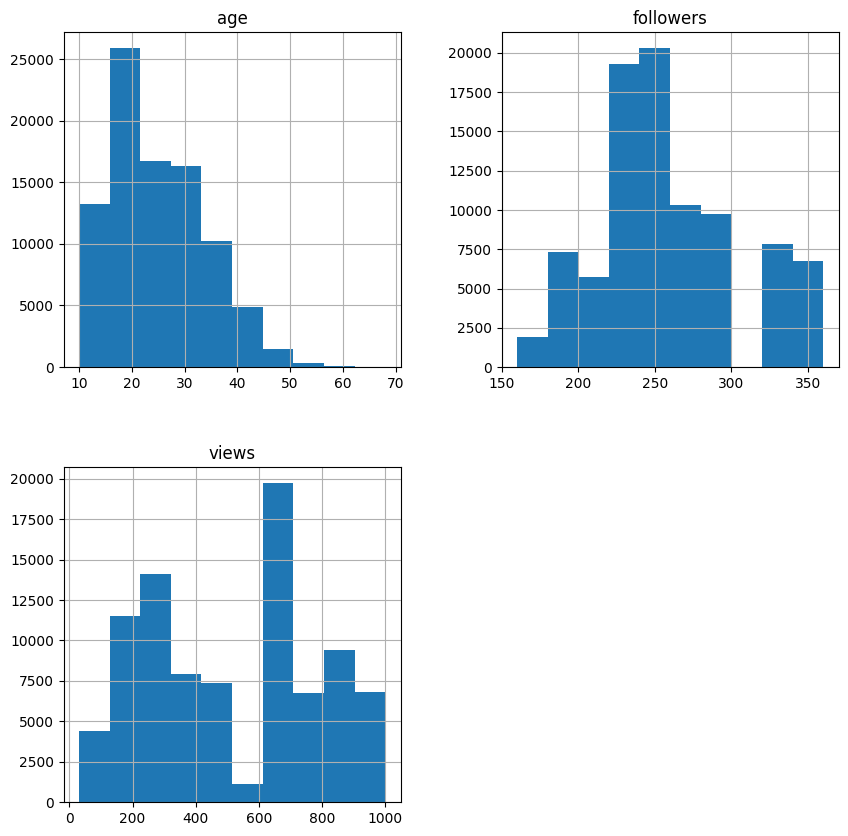

In [ ]:
df[num_features].hist(figsize=(10,10));

From the above graph it can be intrepreted that the maximum no. of the user lie within the approximately (15,25) age group.

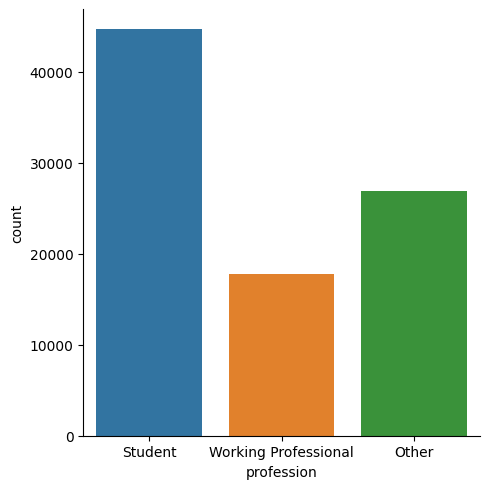

In [ ]:
# Now checking for the categorical features 
sns.catplot(data=df[categ_features],kind='count',x='profession');

We can clearly see from the above graph that most of the user on the platform are students and this also makes sense as the num_features also gave us a age group of 15-25 as highest.
Now using the gender instead of the profession to look for more relations in the data-set.

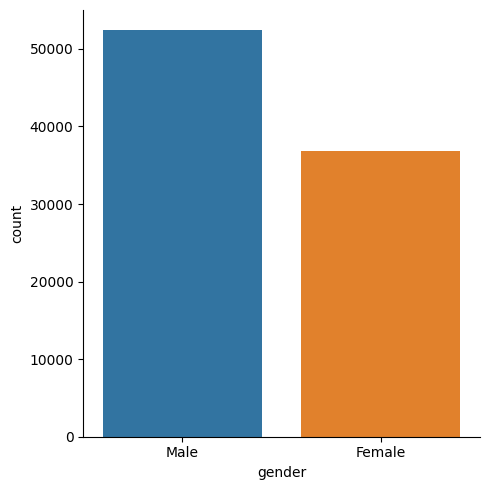

In [ ]:
sns.catplot(data=df[categ_features],kind='count',x='gender')

Hence to sum it up we can say that most frequent user lie between 15-25 age, are students by profession and are generally males.

But all of this doesn't give us enough so that we can find any correlation between these variable and the target variable which is engagement score.

Hence we will generate a heatmap to see any underlying correaltions 

<ipython-input-19-5830acf6fe04>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),fmt='g',annot=True)


<Axes: >

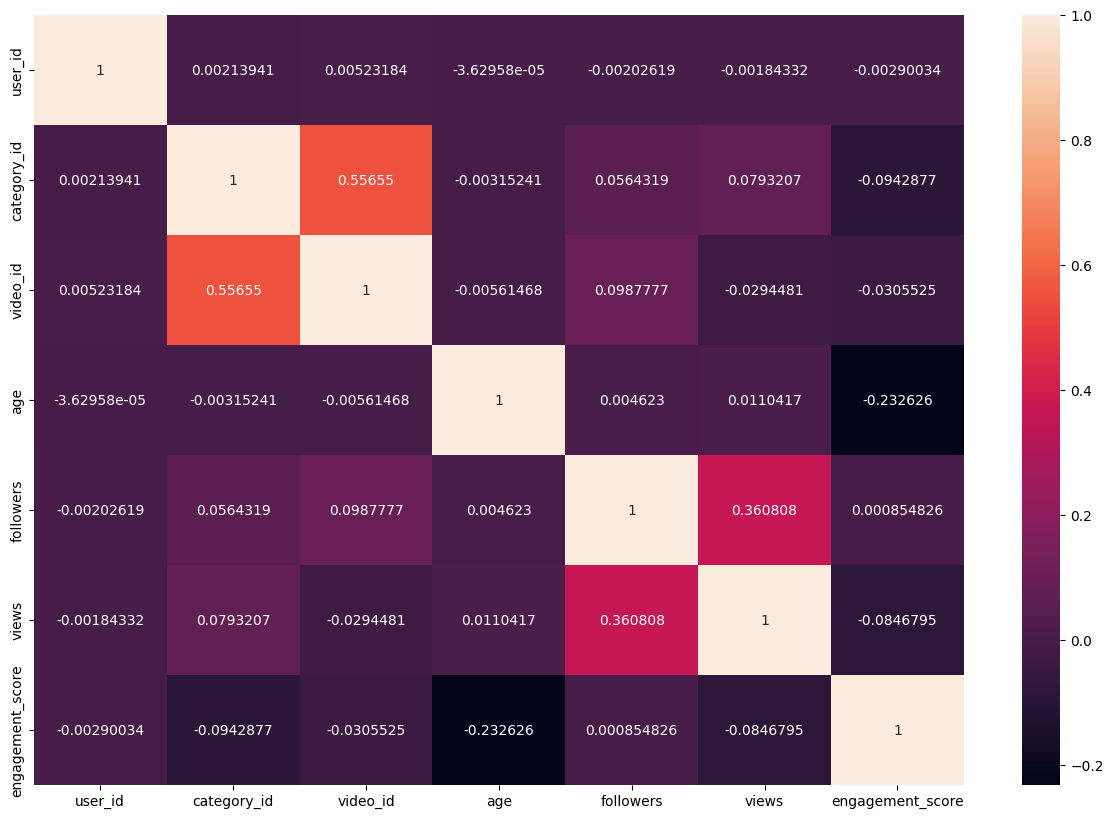

In [ ]:
# doing a feature correlation using the heat map 
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),fmt='g',annot=True)


From the heatmap generated we can see that there are 2 pairs that show correlation between themselves. 
Pair_1 = category_is,video_id
pair_2 = views,followers.
Sadly any of the above features dont havea strong corr with the engagement_score.

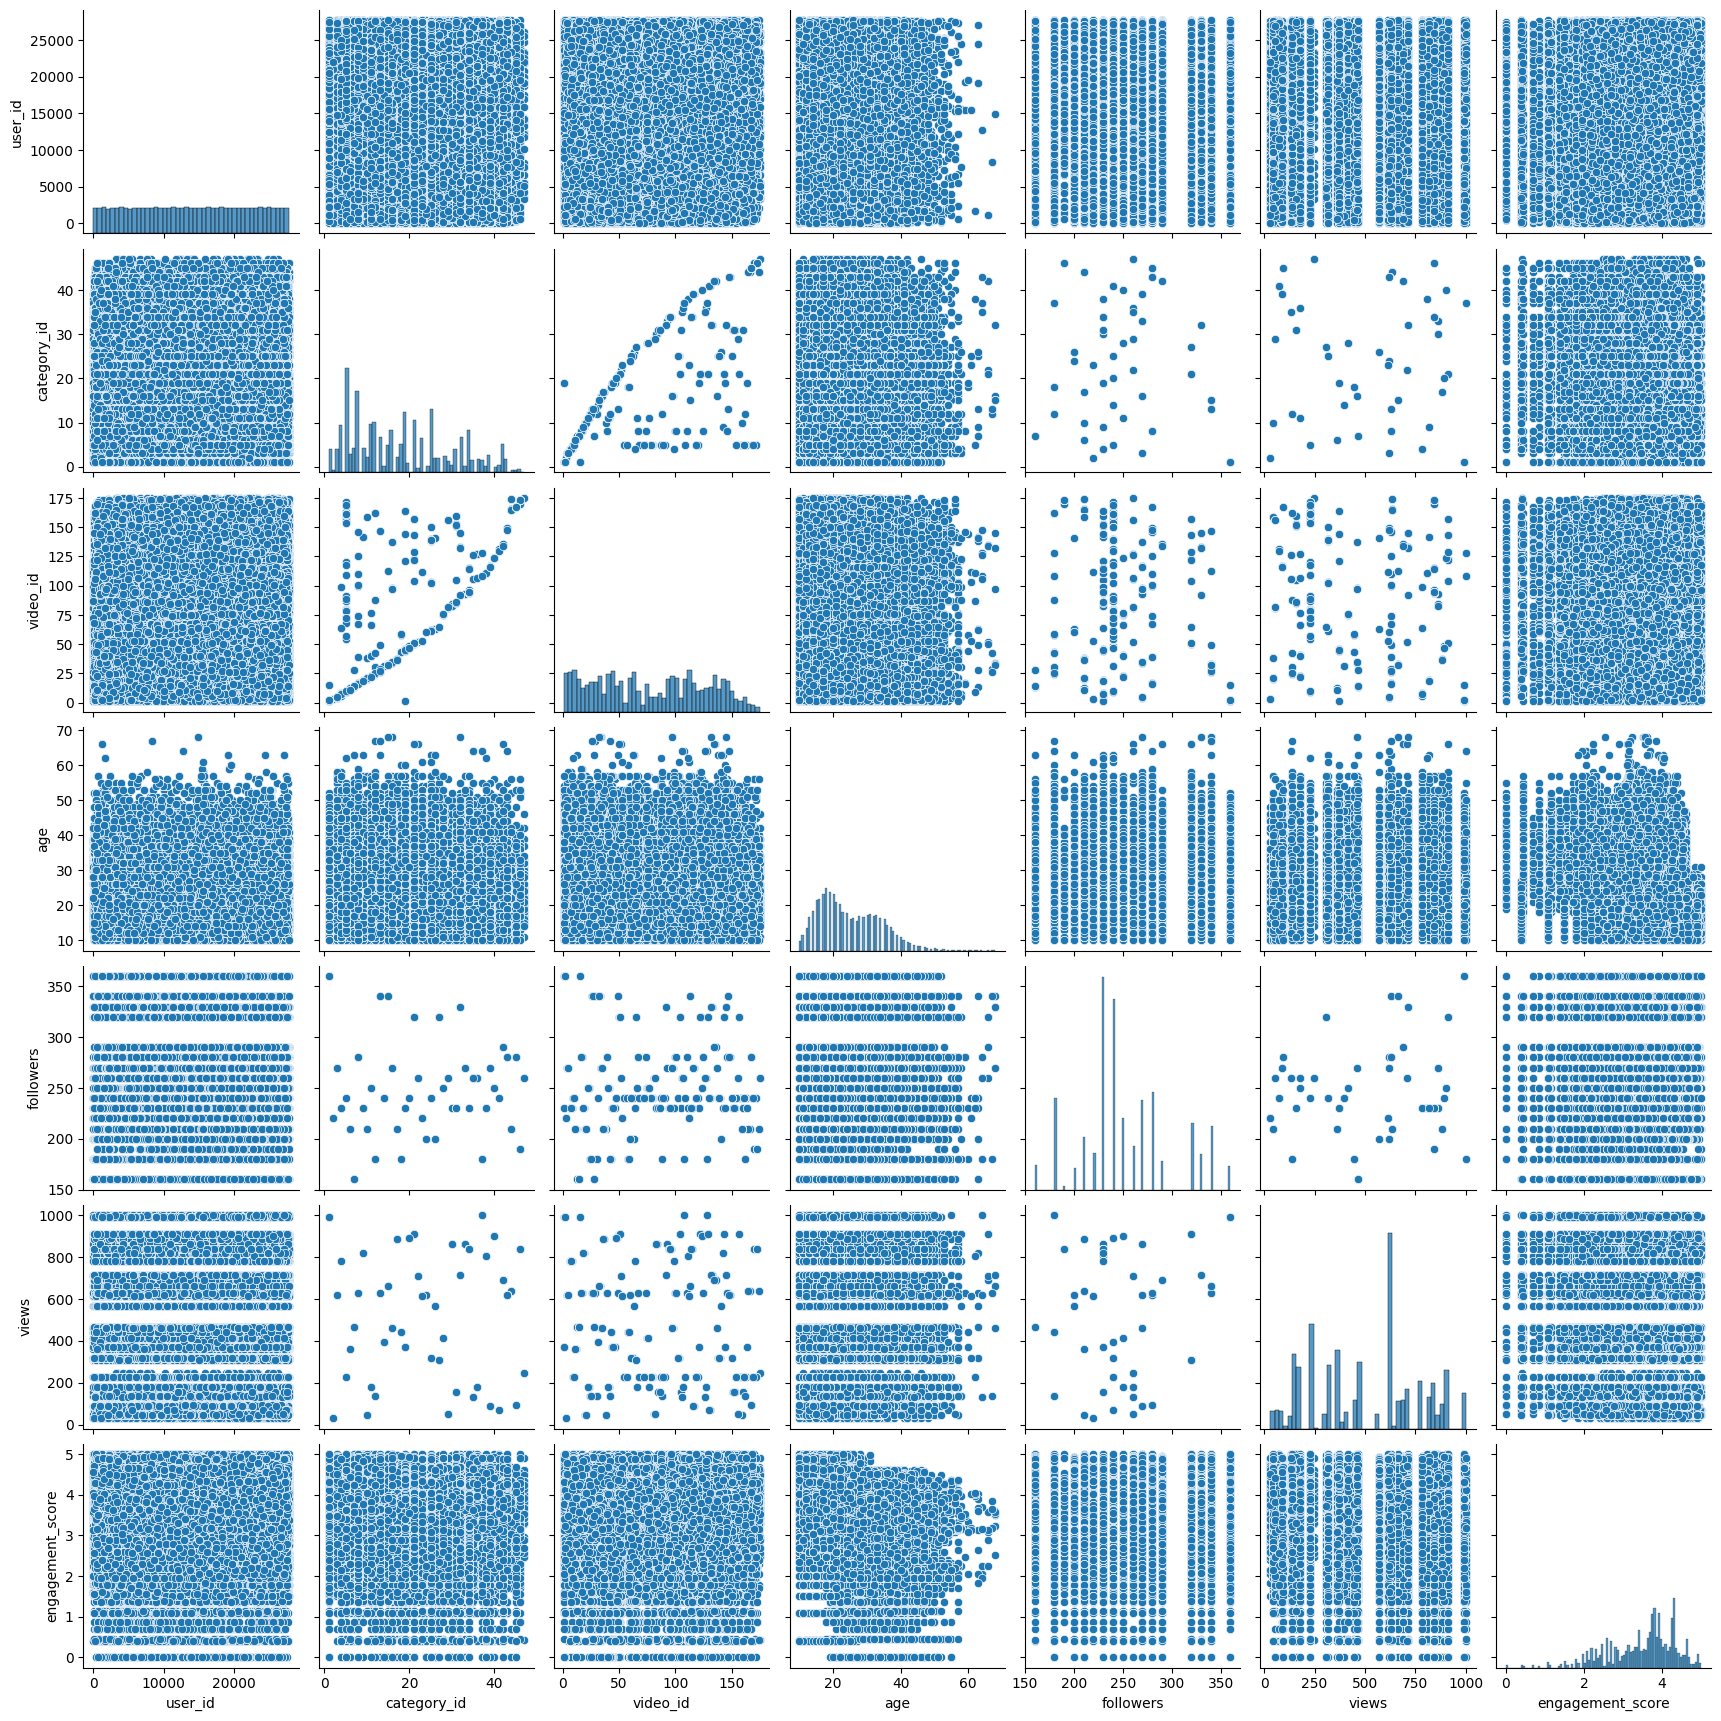

In [ ]:
#We will use pair plot just to confirm the above derived observation 
sns.pairplot(df)

Since we dont have any variable showing direct relation with the engagement score we will have to use feature engineering to generate new feature of the pair 1 and pair 2 variable with the target variable 

In [ ]:
features=['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession',
       'followers', 'views']
target=['engagement_score']
x_train, y_train=df[features],df[target]
df2 = pd.read_csv('/content/train_0OECtn8.csv')
x_test, y_test=df2[features],df2[target]
df_train=pd.concat([x_train,y_train],axis=1)
df_test=pd.concat([x_test,y_test],axis=1)

In [ ]:
grp_by=['user_id']
user_id_features=df_train.groupby(grp_by)['followers'].min().reset_index()
user_id_features.rename(columns={'followers':'min_followers'},inplace=True)
user_id_features['avg_followers']=df_train.groupby(grp_by)['followers'].mean().reset_index()['followers']
user_id_features['max_followers']=df_train.groupby(grp_by)['followers'].max().reset_index()['followers']
user_id_features['sum_followers']=df_train.groupby(grp_by)['followers'].sum().reset_index()['followers']
user_id_features['min_views']=df_train.groupby(grp_by)['views'].min().reset_index()['views']
user_id_features['mean_views']=df_train.groupby(grp_by)['views'].mean().reset_index()['views']
user_id_features['max_views']=df_train.groupby(grp_by)['views'].max().reset_index()['views']
user_id_features['sum_views']=df_train.groupby(grp_by)['views'].sum().reset_index()['views']
grp_by1=['user_id','category_id']
user_id_features1=df_train.groupby(grp_by1)['followers'].min().reset_index()
user_id_features1.rename(columns={'followers':'min_followers_category'},inplace=True)
user_id_features1['avg_followers_category']=df_train.groupby(grp_by1)['followers'].mean().reset_index()['followers']
user_id_features1['max_followers_category']=df_train.groupby(grp_by1)['followers'].max().reset_index()['followers']
user_id_features1['sum_followers_category']=df_train.groupby(grp_by1)['followers'].sum().reset_index()['followers']
user_id_features1['min_views_category']=df_train.groupby(grp_by1)['views'].min().reset_index()['views']
user_id_features1['mean_views_category']=df_train.groupby(grp_by1)['views'].mean().reset_index()['views']
user_id_features1['max_views_category']=df_train.groupby(grp_by1)['views'].max().reset_index()['views']
user_id_features1['sum_views_category']=df_train.groupby(grp_by1)['views'].sum().reset_index()['views']
df_train=pd.merge(df_train,user_id_features,how='left',on=grp_by)
df_test=pd.merge(df_test,user_id_features,how='left',on=grp_by)
df_train=pd.merge(df_train,user_id_features1,how='left',on=grp_by1)
df_test=pd.merge(df_test,user_id_features1,how='left',on=grp_by1)

In [ ]:
grp_by=['user_id']
user_id_features2=df_train.groupby(grp_by)['engagement_score'].min().reset_index()
user_id_features2.rename(columns={'engagement_score':'min_eng_score'},inplace=True)
user_id_features2['avg_eng_score']=df_train.groupby(grp_by)['engagement_score'].mean().reset_index()['engagement_score']
user_id_features2['max_eng_score']=df_train.groupby(grp_by)['engagement_score'].max().reset_index()['engagement_score']
user_id_features2['sum_eng_score']=df_train.groupby(grp_by)['engagement_score'].sum().reset_index()['engagement_score']
grp_by1=['user_id','category_id']
user_id_features3=df_train.groupby(grp_by1)['engagement_score'].min().reset_index()
user_id_features3.rename(columns={'engagement_score':'min_eng_score_category'},inplace=True)
user_id_features3['avg_eng_score_category']=df_train.groupby(grp_by1)['engagement_score'].mean().reset_index()['engagement_score']
user_id_features3['max_eng_score_category']=df_train.groupby(grp_by1)['engagement_score'].max().reset_index()['engagement_score']
user_id_features3['sum_eng_score_category']=df_train.groupby(grp_by1)['engagement_score'].sum().reset_index()['engagement_score']
df_train=pd.merge(df_train,user_id_features2,how='left',on=grp_by)
df_test=pd.merge(df_test,user_id_features2,how='left',on=grp_by)
df_train=pd.merge(df_train,user_id_features3,how='left',on=grp_by1)
df_test=pd.merge(df_test,user_id_features3,how='left',on=grp_by1)

In [ ]:
df_train.columns

Index(['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession',
       'followers', 'views', 'engagement_score', 'min_followers',
       'avg_followers', 'max_followers', 'sum_followers', 'min_views',
       'mean_views', 'max_views', 'sum_views', 'min_followers_category',
       'avg_followers_category', 'max_followers_category',
       'sum_followers_category', 'min_views_category', 'mean_views_category',
       'max_views_category', 'sum_views_category', 'min_eng_score',
       'avg_eng_score', 'max_eng_score', 'sum_eng_score',
       'min_eng_score_category', 'avg_eng_score_category',
       'max_eng_score_category', 'sum_eng_score_category'],
      dtype='object')

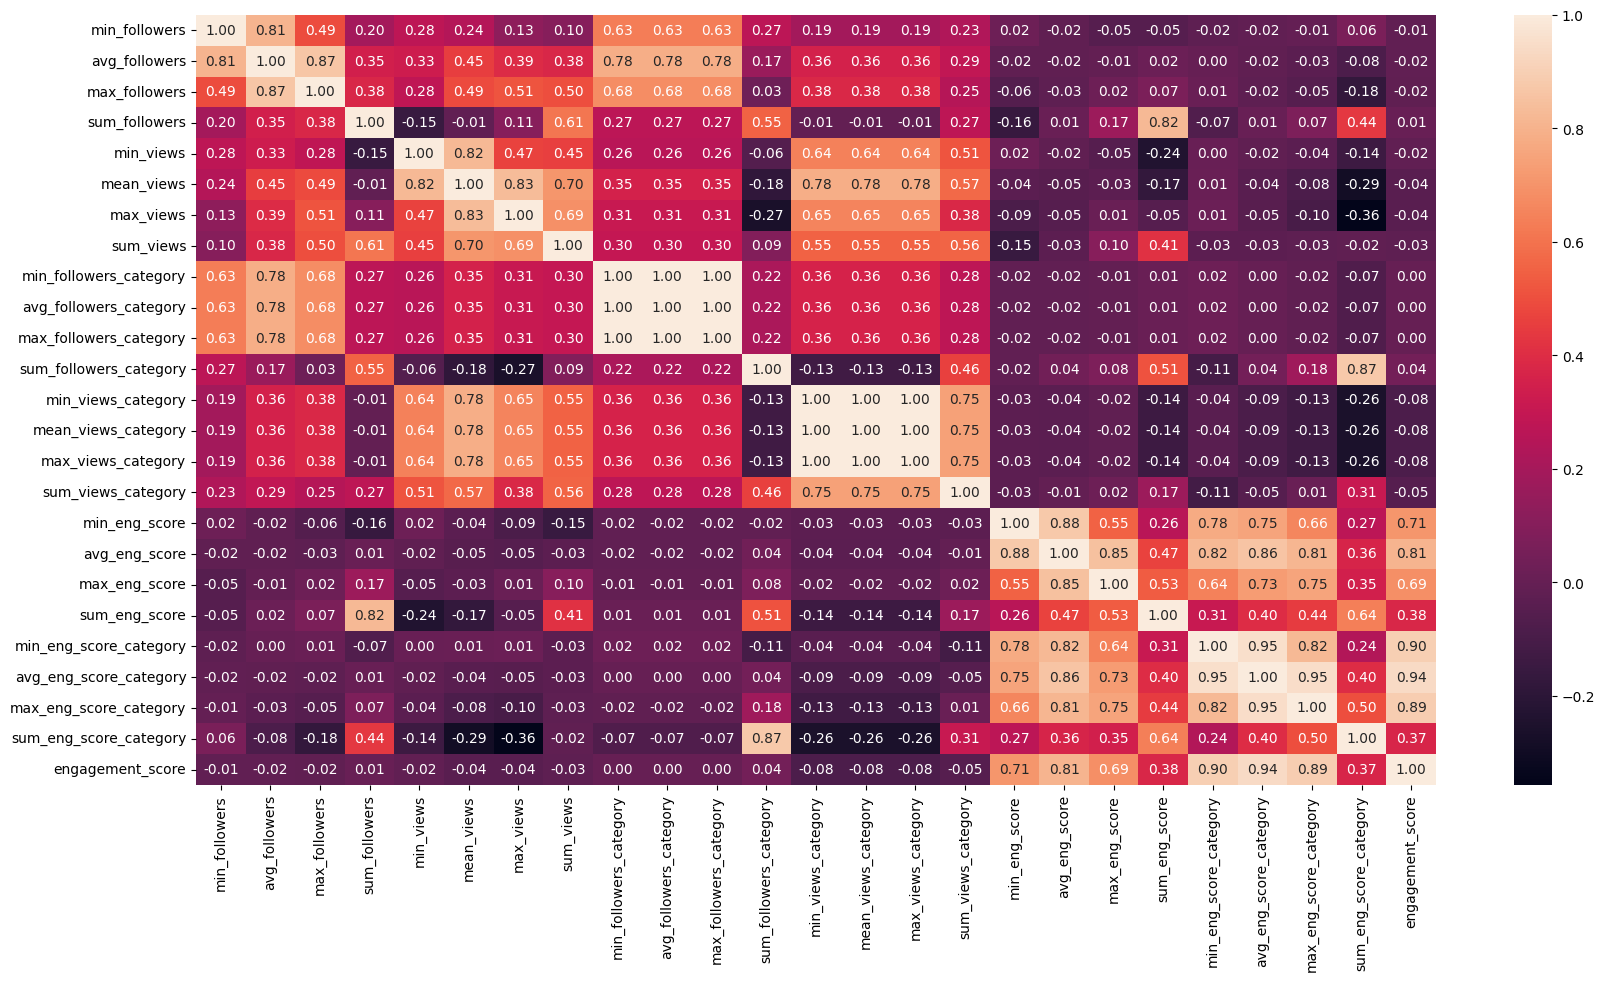

In [ ]:
new_features=['min_followers',
       'avg_followers', 'max_followers', 'sum_followers', 'min_views',
       'mean_views', 'max_views', 'sum_views', 'min_followers_category',
       'avg_followers_category', 'max_followers_category',
       'sum_followers_category', 'min_views_category', 'mean_views_category',
       'max_views_category', 'sum_views_category', 'min_eng_score',
       'avg_eng_score', 'max_eng_score', 'sum_eng_score',
       'min_eng_score_category', 'avg_eng_score_category',
       'max_eng_score_category', 'sum_eng_score_category','engagement_score']
plt.figure(figsize=(20,10))
sns.heatmap(df_train[new_features].corr(),fmt='.2f',annot=True);

In [ ]:
df_corr=(df_train[new_features].corr()['engagement_score']).reset_index()
df_corr.columns=['features','engagement_score']
df_corr.sort_values('engagement_score',ascending=False)

,features,engagement_score
24,engagement_score,1.000000
21,avg_eng_score_category,0.939029
20,min_eng_score_category,0.896414
22,max_eng_score_category,0.891903
17,avg_eng_score,0.805193
16,min_eng_score,0.706391
18,max_eng_score,0.685029
19,sum_eng_score,0.375928
23,sum_eng_score_category,0.371884
11,sum_followers_category,0.041100


In [ ]:
#Label Encoding 'gender'
gender_dict={'Male':0,'Female':1}
df_train['gender']=df_train['gender'].map(gender_dict)
df_test['gender']=df_test['gender'].map(gender_dict)

In [ ]:
profession_dict={'Student':0,'Working Professional':1,'Other':2}
df_train['profession']=df_train['profession'].map(profession_dict)
df_test['profession']=df_test['profession'].map(profession_dict)

In [ ]:
features_to_use=['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession',
       'followers', 'views', 'min_followers',
       'avg_followers', 'max_followers', 'sum_followers', 'min_views',
       'mean_views', 'max_views', 'sum_views', 'min_followers_category',
       'avg_followers_category', 'max_followers_category',
       'sum_followers_category', 'min_views_category', 'mean_views_category',
       'max_views_category', 'sum_views_category', 'min_eng_score',
       'avg_eng_score', 'max_eng_score', 'sum_eng_score',
       'min_eng_score_category', 'avg_eng_score_category',
       'max_eng_score_category', 'sum_eng_score_category']
target=['engagement_score']

In [ ]:
df_test.dropna(inplace=True)

In [ ]:
X_train,y_train=df_train[features_to_use],df_train[target]
X_test,y_test=df_test[features_to_use],df_test[target]

In [ ]:
def model_performance(y_test,y_pred):
    r2=round(r2_score(y_test,y_pred),3)
    rmse=round(np.sqrt(mean_squared_error(y_test,y_pred)),3)
    return r2,rmse

In [ ]:


def limit_predictions(predictions, min_value, max_value):
    """
    Limits the given predictions to the range [min_value, max_value].
    """
    return np.clip(predictions, min_value, max_value)

model_name=['LinearRegression','XGBRegressor','RandomForestRegressor','CatBoostRegressor']
model_object=[LinearRegression(),XGBRegressor(),RandomForestRegressor(),CatBoostRegressor()]
model_r2_result=[]
model_rmse_result=[]
for i,model in enumerate(model_object):
    print('Running ',model_name[i])
    if model_name[i]=='CatBoostRegressor':
        model.fit(X_train,y_train,cat_features=['user_id', 'category_id', 'gender', 'profession'],verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_pred=np.array(y_pred).reshape(-1,1)
    #engagement score liest between 0 and 5. While prediting it is possible that predicted scores are beyond these
    #limits so keeping this in mind I am limiting the predictions in 0 to 5 range.
    accurate_y_pred=limit_predictions(y_pred,0,5)
    model_r2,model_rmse=model_performance(y_test,accurate_y_pred)
    model_r2_result.append(model_r2)
    model_rmse_result.append(model_rmse)


Running  LinearRegression
Running  XGBRegressor
Running  RandomForestRegressor


<ipython-input-33-ddfd2bc98b22>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


Running  CatBoostRegressor


In [ ]:
results = PrettyTable(['Performance_Metric']+model_name)
results.add_row(['R2_Score']+model_r2_result)
results.add_row(['RMSE_Score']+model_rmse_result)
print(results)


+--------------------+------------------+--------------+-----------------------+-------------------+
| Performance_Metric | LinearRegression | XGBRegressor | RandomForestRegressor | CatBoostRegressor |
+--------------------+------------------+--------------+-----------------------+-------------------+
|      R2_Score      |      0.882       |    0.915     |          0.97         |       0.887       |
|     RMSE_Score     |      0.297       |    0.251     |         0.149         |       0.291       |
+--------------------+------------------+--------------+-----------------------+-------------------+
